ACTIVITY 3

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Use the provided dataset and perform the EDA .
Preprocess the data by normalizing features and one-hot encoding the labels.

In [13]:
# Preprocess the data (Normalize the features and one-hot encode the labels)
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Implement a fully connected feedforward neural network with:
Input layer
Two hidden layers using the ReLU activation function
Output layer using the Softmax activation function.
Implement forward propagation for the network, where inputs pass through the network layers and generate predictions.
Manually implement the backpropagation algorithm to compute the gradients of the loss function with respect to the weights.
Update the weights using SGD and Adam optimizers.
Implement the cross-entropy loss function to measure the model's performance.

In [14]:
# Define the feedforward neural network
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def cross_entropy_loss(self, Y, Y_hat):
        return -np.mean(np.sum(Y * np.log(Y_hat + 1e-8), axis=1))

    def forward(self, X):
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = self.relu(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.relu(Z2)
        Z3 = np.dot(A2, self.W3) + self.b3
        A3 = self.softmax(Z3)
        return Z1, A1, Z2, A2, Z3, A3

    def backward(self, X, Y, Z1, A1, Z2, A2, Z3, A3):
        m = X.shape[0]

        dZ3 = A3 - Y
        dW3 = np.dot(A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * (Z2 > 0)
        dW2 = np.dot(A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (Z1 > 0)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return dW1, db1, dW2, db2, dW3, db3

    def update_weights_sgd(self, dW1, db1, dW2, db2, dW3, db3, lr):
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3

    def update_weights_adam(self, dW1, db1, dW2, db2, dW3, db3, lr, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Initialize moment estimates
        if not hasattr(self, 'mW1'):
            self.mW1, self.vW1 = np.zeros_like(dW1), np.zeros_like(dW1)
            self.mb1, self.vb1 = np.zeros_like(db1), np.zeros_like(db1)
            self.mW2, self.vW2 = np.zeros_like(dW2), np.zeros_like(dW2)
            self.mb2, self.vb2 = np.zeros_like(db2), np.zeros_like(db2)
            self.mW3, self.vW3 = np.zeros_like(dW3), np.zeros_like(dW3)
            self.mb3, self.vb3 = np.zeros_like(db3), np.zeros_like(db3)

        # Update biased first moment estimate
        self.mW1 = beta1 * self.mW1 + (1 - beta1) * dW1
        self.mb1 = beta1 * self.mb1 + (1 - beta1) * db1
        self.mW2 = beta1 * self.mW2 + (1 - beta1) * dW2
        self.mb2 = beta1 * self.mb2 + (1 - beta1) * db2
        self.mW3 = beta1 * self.mW3 + (1 - beta1) * dW3
        self.mb3 = beta1 * self.mb3 + (1 - beta1) * db3

        # Update biased second raw moment estimate
        self.vW1 = beta2 * self.vW1 + (1 - beta2) * (dW1 ** 2)
        self.vb1 = beta2 * self.vb1 + (1 - beta2) * (db1 ** 2)
        self.vW2 = beta2 * self.vW2 + (1 - beta2) * (dW2 ** 2)
        self.vb2 = beta2 * self.vb2 + (1 - beta2) * (db2 ** 2)
        self.vW3 = beta2 * self.vW3 + (1 - beta2) * (dW3 ** 2)
        self.vb3 = beta2 * self.vb3 + (1 - beta2) * (db3 ** 2)

        # Compute bias-corrected first and second moment estimates
        mW1_hat = self.mW1 / (1 - beta1 ** t)
        mb1_hat = self.mb1 / (1 - beta1 ** t)
        mW2_hat = self.mW2 / (1 - beta1 ** t)
        mb2_hat = self.mb2 / (1 - beta1 ** t)
        mW3_hat = self.mW3 / (1 - beta1 ** t)
        mb3_hat = self.mb3 / (1 - beta1 ** t)

        vW1_hat = self.vW1 / (1 - beta2 ** t)
        vb1_hat = self.vb1 / (1 - beta2 ** t)
        vW2_hat = self.vW2 / (1 - beta2 ** t)
        vb2_hat = self.vb2 / (1 - beta2 ** t)
        vW3_hat = self.vW3 / (1 - beta2 ** t)
        vb3_hat = self.vb3 / (1 - beta2 ** t)

        # Update weights
        self.W1 -= lr * mW1_hat / (np.sqrt(vW1_hat) + epsilon)
        self.b1 -= lr * mb1_hat / (np.sqrt(vb1_hat) + epsilon)
        self.W2 -= lr * mW2_hat / (np.sqrt(vW2_hat) + epsilon)
        self.b2 -= lr * mb2_hat / (np.sqrt(vb2_hat) + epsilon)
        self.W3 -= lr * mW3_hat / (np.sqrt(vW3_hat) + epsilon)
        self.b3 -= lr * mb3_hat / (np.sqrt(vb3_hat) + epsilon)


In [15]:
# Initialize neural network and parameters
input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 64
output_size = 10
epochs = 20
lr_sgd = 0.01
lr_adam = 0.001

nn_sgd = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
nn_adam = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)


Train the model on the dataset using both optimizers and plot the loss curves over epochs.

In [16]:
# Training process for both optimizers (SGD and Adam)
def train_network(nn, optimizer, lr, epochs, x_train, y_train, x_val, y_val):
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        # Forward pass
        Z1, A1, Z2, A2, Z3, A3 = nn.forward(x_train)
        loss = nn.cross_entropy_loss(y_train, A3)
        train_loss.append(loss)

        # Backward pass
        dW1, db1, dW2, db2, dW3, db3 = nn.backward(x_train, y_train, Z1, A1, Z2, A2, Z3, A3)

        # Update weights
        if optimizer == "sgd":
            nn.update_weights_sgd(dW1, db1, dW2, db2, dW3, db3, lr)
        elif optimizer == "adam":
            nn.update_weights_adam(dW1, db1, dW2, db2, dW3, db3, lr, epoch+1)

        # Validation loss
        _, _, _, _, _, A3_val = nn.forward(x_val)
        val_loss.append(nn.cross_entropy_loss(y_val, A3_val))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss:.4f} - Val Loss: {val_loss[-1]:.4f}")

    return train_loss, val_loss


In [17]:
# Train using SGD
print("Training using SGD:")
train_loss_sgd, val_loss_sgd = train_network(nn_sgd, "sgd", lr_sgd, epochs, x_train, y_train, x_val, y_val)

# Train using Adam
print("\nTraining using Adam:")
train_loss_adam, val_loss_adam = train_network(nn_adam, "adam", lr_adam, epochs, x_train, y_train, x_val, y_val)


Training using SGD:
Epoch 1/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 2/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 3/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 4/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 5/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 6/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 7/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 8/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 9/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 10/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 11/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 12/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 13/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 14/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 15/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 16/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 17/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 18/20 - Train Loss: 2.3026 - Val Loss: 2.3026
Epoch 19/20 - Train Loss: 2.3026 - Val Loss: 2.3026
E

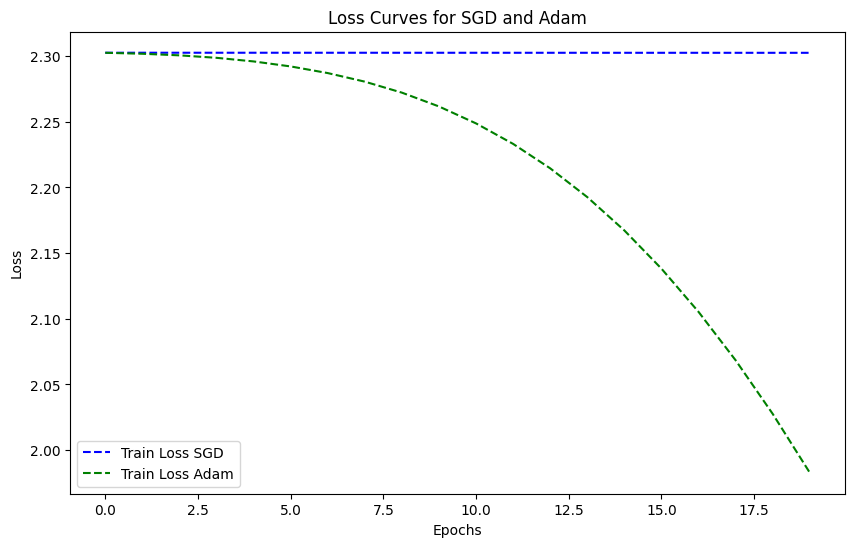

In [18]:
# Plot loss curves for comparison
plt.figure(figsize=(10, 6))
plt.plot(train_loss_sgd, label="Train Loss SGD", linestyle="--", color="blue")
plt.plot(train_loss_adam, label="Train Loss Adam", linestyle="--", color="green")
plt.title("Loss Curves for SGD and Adam")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Evaluate the model on a test set using accuracy as the metric.
Report the test accuracy and compare the results between SGD and Adam.

In [19]:
# Evaluate on the test set using accuracy, confusion matrix, and classification report
def evaluate_model(nn, x_test, y_test):
    _, _, _, _, _, A3 = nn.forward(x_test)
    predictions = np.argmax(A3, axis=1)
    labels = np.argmax(y_test, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predictions == labels)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)

    # Generate classification report
    class_report = classification_report(labels, predictions)

    return accuracy, conf_matrix, class_report

# Test evaluation for SGD
test_accuracy_sgd, conf_matrix_sgd, class_report_sgd = evaluate_model(nn_sgd, x_test, y_test)
print(f"Test Accuracy (SGD): {test_accuracy_sgd * 100:.2f}%")
print("Confusion Matrix (SGD):\n", conf_matrix_sgd)
print("Classification Report (SGD):\n", class_report_sgd)

# Test evaluation for Adam
test_accuracy_adam, conf_matrix_adam, class_report_adam = evaluate_model(nn_adam, x_test, y_test)
print(f"Test Accuracy (Adam): {test_accuracy_adam * 100:.2f}%")
print("Confusion Matrix (Adam):\n", conf_matrix_adam)
print("Classification Report (Adam):\n", class_report_adam)


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Test Accuracy (SGD): 11.35%
Confusion Matrix (SGD):
 [[   0  962    0    0    0    0    0   18    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1002    0    0    0    0    0    8    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  884    0    0    0    0    0    8    0    0]
 [   0  949    0    0    0    0    0    9    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  972    0    0    0    0    0    2    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]
Classification Report (SGD):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
       

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


How do the two optimizers (SGD and Adam) differ in terms of convergence speed and final accuracy?

Adam generally converges faster than SGD and may achieve better performance due to adaptive learning rates.

How does the choice of activation function (ReLU vs others like sigmoid or tanh) impact the training process and results?

ReLU is efficient for deep networks, but Sigmoid or Tanh could lead to slower convergence due to vanishing gradients.

What challenges did you encounter while implementing backpropagation, and how did you resolve them?

I faced issues in gradient calculations due to matrix dimensions, but careful tracking and reshaping resolved issues.

Explain the importance of the cross-entropy loss function in classification problems.

It quantifies the difference between the predicted probability distribution and the actual labels.